In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read Data 
test = pd.read_csv('test.csv')
train =pd.read_csv('train.csv')
train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# EDA

In [4]:
df_malignant = train.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_malignant.columns.values)
for i in categories:
    counts.append((i, df_malignant[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,malignant,15294
1,highly_malignant,1595
2,rude,8449
3,threat,478
4,abuse,7877
5,loathe,1405


Text(0.5, 0, 'category')

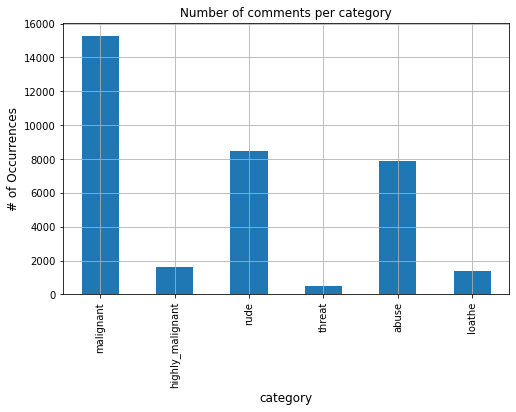

In [5]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

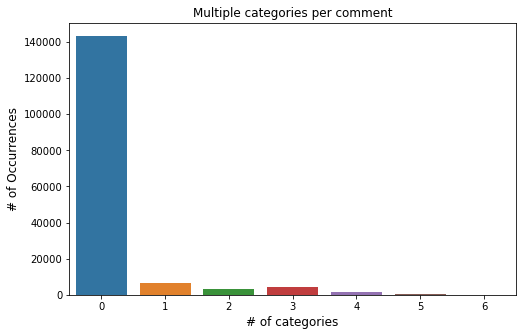

In [6]:
rowsums = train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [7]:
print('Percentage of comments that are not labelled:')
print(len(train[(train['malignant']==0) & (train['highly_malignant']==0) & 
                      (train['rude']==0) & (train['threat']== 0) & (train['abuse']==0) & 
                      (train['loathe']==0)]) / len(train))

Percentage of comments that are not labelled:
0.8983211235124177


<AxesSubplot:>

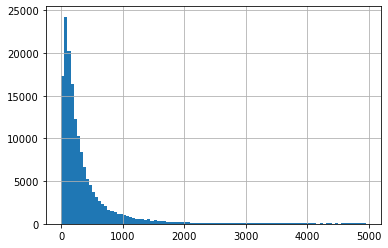

In [8]:
lens = train.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

In [9]:
## Check for missing values 
print('Number of missing comments in comment text:')
train['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

# Data processing

In [10]:
train['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [11]:
import re
import string
import nltk
from nltk.corpus import  stopwords
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure','us'])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))

In [13]:
train['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

In [14]:
def preprocess_text(text):
    #text = text.lower()
    # Replace money symbols 
    text = re.sub(r'£|\$', ' ',text)
    # remove punctuations 
    text =  re.sub(r'[^\w\d\s]','',text)
    # remove numbers 
    text = re.sub(r'\d+(\.\d+)?', ' ',text)
    # Remove spacial char
    text = re.sub(r'[%#@$&!+|ð¦±_]','',text)          
    # Replace whitespace between terms with a single space
    text = re.sub(r'\s+', ' ',text)
    # Remove leading and trailing whitespace
    text = re.sub(r'^\s+|\s+?$', '',text)
    # Removes words of up to 3 characters entirely
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # remove STOP words
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [15]:
train['comment_text'] = train['comment_text'].map(lambda com : preprocess_text(com))

In [16]:
train['comment_text'][0]

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

In [17]:
# Preprocessing Test Data

test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

In [18]:
test['comment_text'][0]

'yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time'

In [19]:
test['comment_text'] = test['comment_text'].map(lambda com : preprocess_text(com))

In [20]:
test['comment_text'][1]

'rfc title fine imo'

# Modeling

In [21]:
l = ['malignant','highly_malignant','rude', 'threat','abuse','loathe']

X = train.loc[:,['comment_text']]
y = train.loc[:,l]

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=33, shuffle=True)

In [23]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(143613, 1) (15958, 1)
(143613, 6) (15958, 6)


In [24]:
y_test.head()

,malignant,highly_malignant,rude,threat,abuse,loathe
119907,0,0,0,0,0,0
124337,0,0,0,0,0,0
148004,0,0,0,0,0,0
11318,0,0,0,0,0,0
110630,1,0,1,0,1,1


In [25]:
train_lines = []
for row in range(0,X_train.shape[0]):
  train_lines.append(' '.join(str(x) for x in X_train.iloc[row,:]))

test_lines = []
for row in range(0,X_test.shape[0]):
  test_lines.append(' '.join(str(x) for x in X_test.iloc[row,:]))

predtest_lines = []
for row in range(0,test.shape[0]):
  predtest_lines.append(' '.join(str(x) for x in test.iloc[row,1:]))

In [26]:
predtest_lines

['bitch rule succesful ever whats hating sad mofuckas bitch slap pethedic white faces get kiss ass guys sicken rule pride music man diss shit nothin wrong bein like tupac brother fuckin white boys get things right next time',
 'rfc title fine imo',
 'sources zawe ashton lapland',
 'look back source information updated correct form guess source updated shall update information thank message',
 'anonymously edit articles',
 'thank understanding think highly would revert without discussion',
 'please add nonsense wikipedia edits considered vandalism quickly undone would like experiment please use sandbox instead thank',
 'dear god site horrible',
 'fool believe numbers correct number lies ponder numbers carefully error persist long time continues reproduce latest reproduction know encyclopædia britannica almanac wich states magnittude fair enough victims today lot guess people come number impresses enough know know shameless lucky number throw air',
 'double redirects fixing double redire

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

#countvector = CountVectorizer(ngram_range=(1,2))
countvector = CountVectorizer()
X_train_cv = countvector.fit_transform(train_lines)
X_test_cv = countvector.transform(test_lines)

test_cv = countvector.transform(predtest_lines)

In [28]:
#Using TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

tfidfvector = TfidfTransformer()
X_train_tf = tfidfvector.fit_transform(X_train_cv)
X_test_tf = tfidfvector.fit_transform(X_test_cv)

test_tf = tfidfvector.fit_transform(test_cv)

In [29]:
X_lines = []
for row in range(0,X.shape[0]):
  X_lines.append(' '.join(str(x) for x in X.iloc[row,:]))

In [30]:

X_cv = countvector.transform(X_lines)

X_tf = tfidfvector.fit_transform(X_cv)

# Apply LINEAR SVC model

In [31]:
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

model = LinearSVC(class_weight='balanced',C=0.5)
models = MultiOutputClassifier(model)

In [32]:
## train the model 
models.fit(X_tf, y)

MultiOutputClassifier(estimator=LinearSVC(C=0.5, class_weight='balanced'))

In [33]:
preds = models.predict(X_test_tf)
preds

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [34]:
# now test model on given test dataset
predssv = models.predict(test_tf)
predssv

array([[1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]], dtype=int64)

In [35]:
y1 = np.array(y_train)
y2 = np.array(y_test)

In [36]:
## Now check the accuracy of the model 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#print(confusion_matrix(y2,preds))
print(classification_report(y2,preds))
print(accuracy_score(y2,preds))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1534
           1       0.41      1.00      0.58       153
           2       0.80      1.00      0.89       831
           3       0.58      1.00      0.73        51
           4       0.68      1.00      0.81       773
           5       0.52      1.00      0.69       149

   micro avg       0.71      0.99      0.83      3491
   macro avg       0.63      1.00      0.76      3491
weighted avg       0.73      0.99      0.84      3491
 samples avg       0.08      0.10      0.09      3491

0.933450307056022


# LogisticRegression for Multi-class

In [37]:
# LogisticRegression not supports multi-lable class,therefore, we wrap LogisticRegression in the OneVsRestClassifier.
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier    ## Binary Relevences

lr_model = LogisticRegression(class_weight='balanced',C=3.0)
clf = OneVsRestClassifier(lr_model)

In [38]:
# train the model 
clf.fit(X_tf, y)

OneVsRestClassifier(estimator=LogisticRegression(C=3.0,
                                                 class_weight='balanced'))

In [39]:
preds_clf = clf.predict(X_test_tf)
preds_clf

array([[1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#print(confusion_matrix(y2,preds_clf))
print(classification_report(y2,preds_clf))
print(accuracy_score(y2,preds_clf))

              precision    recall  f1-score   support

           0       0.75      0.98      0.84      1534
           1       0.35      1.00      0.52       153
           2       0.78      1.00      0.87       831
           3       0.38      1.00      0.55        51
           4       0.64      1.00      0.78       773
           5       0.40      1.00      0.57       149

   micro avg       0.66      0.99      0.79      3491
   macro avg       0.55      0.99      0.69      3491
weighted avg       0.69      0.99      0.81      3491
 samples avg       0.08      0.10      0.09      3491

0.9193507958390775


# Naive Bayes model

In [41]:
# Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrap Naive Bayes in the OneVsRestClassifier.
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

NB = MultinomialNB(fit_prior=True, class_prior=None)
NB_clf = OneVsRestClassifier(NB)

In [42]:
# train the model 
NB_clf.fit(X_tf, y)

OneVsRestClassifier(estimator=MultinomialNB())

In [43]:
preds_NB_clf = NB_clf.predict(X_test_tf)
preds_NB_clf

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [44]:
# Now check the accuracy of the model 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y2,preds_NB_clf))
print(accuracy_score(y2,preds_NB_clf))

              precision    recall  f1-score   support

           0       0.99      0.23      0.38      1534
           1       0.00      0.00      0.00       153
           2       0.99      0.17      0.29       831
           3       0.00      0.00      0.00        51
           4       0.97      0.09      0.17       773
           5       0.00      0.00      0.00       149

   micro avg       0.99      0.16      0.28      3491
   macro avg       0.49      0.08      0.14      3491
weighted avg       0.89      0.16      0.27      3491
 samples avg       0.02      0.01      0.01      3491

0.9006141120441158


# Output:
Here we can see that our Linear SVC classification. model gives us best accuracy for such multi-label class datasets